In [122]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

In [96]:
BATCH_SIZE = 50

In [107]:
#this is from pytorch documentation for training on imagenet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # they do it centered
    transforms.RandomHorizontalFlip(), #if we flip it before getting the representation then we have to do it for the diffusin model too
    transforms.ToTensor(),
    normalize, #seems that they don't do it at least for the SSL
])

In [111]:
#training dataset
train_dataset = datasets.ImageFolder(
    root='../data/train',
    transform=transform
)

# validation dataset
valid_dataset = datasets.ImageFolder(
    root='../data/val',
    transform=transform
)

#training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)

#validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

In [112]:
#train_img.shape = [BATCH_SIZE, 3, X_SIZE, Y_SIZE], classes.shape = [BATCH_SIZE]
train_iterator=iter(train_loader)
train_imgs, classes = next(train_iterator)
print(classes)


#for some motivations here the classes are all zeros
valid_iterator=iter(valid_loader)
val_imgs, classes = next(valid_iterator)
print(classes)


tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


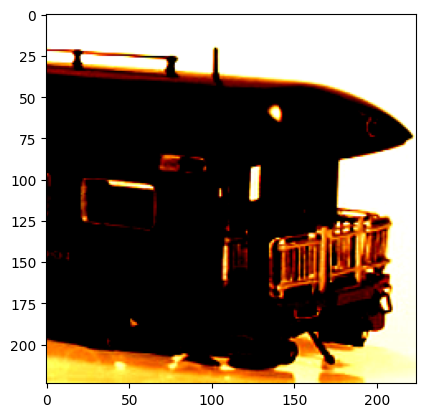

In [116]:
plt.imshow(train_imgs[6].permute(1, 2, 0))

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [135]:
class DinoHead(torch.nn.Module):

    def __init__(self, in_dim=2048, out_dim=60000, hidden_dim=4096, bottleneck_dim=256):
        super().__init__()

        self.mlp = torch.nn.Sequential(*[
            torch.nn.Linear(in_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, bottleneck_dim)
        ])
        self.last_layer = torch.nn.Linear(bottleneck_dim, out_dim, bias=False)

    def forward(self, x):
        x = self.mlp(x)
        return x

In [136]:
dino_model = torch.hub.load_state_dict_from_url("https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain/dino_resnet50_pretrain_full_checkpoint.pth", map_location=device)['teacher']
dino_model = {k.replace("backbone.", ""): v for k, v in dino_model.items()}

In [137]:
resnet50 = models.resnet50()
resnet50.fc = torch.nn.Identity()
resnet50.head = DinoHead()
resnet50.load_state_dict(dino_model, strict=True)
resnet50.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [138]:
backbone = resnet50(train_imgs)
head = resnet50.head(backbone)
output = resnet50.head.last_layer(head)
output.shape

torch.Size([7, 60000])

In [140]:
head.shape

torch.Size([7, 256])

In [141]:
backbone.shape

torch.Size([7, 2048])

Below is code for supervised model

In [142]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Identity()
resnet50.to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\anton/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [143]:
output = resnet50(train_imgs)
output.shape

torch.Size([7, 2048])